In [30]:
import pandas as pd 
import numpy as np 
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
# from pandas.tools.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt
# from pandas.tools.plotting import lag_plot
from pandas.plotting import lag_plot
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
import seaborn as sns
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing the Dataset

kpiName = 'MoU Overall'
circleName = 'MAHARASHTRA'
howIndiaTalksDf = pd.read_csv('C:/Users/piyush12.kumar/PycharmProjects/fileRead/foreCasting/how_india_talks_[2019-11-01, 2020-02-23].csv')
howIndiaTalksDf = howIndiaTalksDf.loc[howIndiaTalksDf['CIRCLE'] == circleName]
howIndiaTalksDf[['First', 'Last']] = howIndiaTalksDf.TIME_STAMP.str.split(" ", expand=True, )
howIndiaTalksDf = howIndiaTalksDf.loc[howIndiaTalksDf['Last'] == "16"]
data = howIndiaTalksDf[['TIME_STAMP', kpiName]]
data.head()

,TIME_STAMP,MoU Overall
380,2019-11-01 16,36557861.15
932,2019-11-02 16,36197072.99
1484,2019-11-03 16,33305300.94
2036,2019-11-04 16,37308981.02
2588,2019-11-05 16,37237728.36


,TIME_STAMP,MoU_Overall,Year,Day,Month,time
380,2019-11-01 16,36557861.15,2019,1,11,2019-11-01
932,2019-11-02 16,36197072.99,2019,2,11,2019-11-02
1484,2019-11-03 16,33305300.94,2019,3,11,2019-11-03
2036,2019-11-04 16,37308981.02,2019,4,11,2019-11-04
2588,2019-11-05 16,37237728.36,2019,5,11,2019-11-05


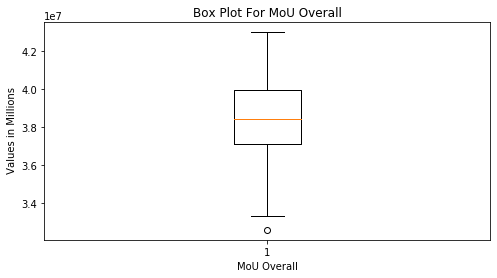

In [31]:
data.columns = [c.replace(' ', '_') for c in data.columns]
plt.figure(figsize=(8,4))
plt.boxplot(data.MoU_Overall)
plt.title('Box Plot For MoU Overall')
plt.xlabel('MoU Overall')
plt.ylabel(' Values in Millions')
# plt.show()
dates = pd.date_range(start='2019-11-01 00:00:00', freq='D', periods=len(data))

dates[0:5]
data['Year']= dates.year
data['Day']= dates.day
data['Month']= dates.month
data.head()
data['time'] = dates
data.head()





In [32]:
data.set_index('time',inplace=True)
data.head()
mou_ts = data['MoU_Overall']
mou_ts[0:5]

# Modeling
data = pd.DataFrame(mou_ts.copy())
data.head()

# Splitting Train and Test Length
train_len = int(np.ceil(len(data) * 0.75))
train=data[0:train_len] 
test=data[train_len:]
print('Train data length :',len(train))
print('Test  data length :',len(test))
x_train = train.drop('MoU_Overall', axis=1)
x_test = test.drop('MoU_Overall', axis=1)
y_train = train[['MoU_Overall']]
y_test = test[['MoU_Overall']]

Train data length : 87
Test  data length : 28


In [33]:
# Model 1: Auto Regressive
# Auto regression model creates a lag data so that correlation of the created lag is high with the original data. No.of lag can be defined manually by seeing ACF plot. By default the algorithm shows the best lag.

model = AR(train)
model_fit = model.fit()
#How many lags considered statistically, what are their beta values
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 12
Coefficients: const              5.586254e+06
L1.MoU_Overall     2.858892e-01
L2.MoU_Overall    -2.345122e-02
L3.MoU_Overall     2.109472e-01
L4.MoU_Overall    -2.739731e-01
L5.MoU_Overall     5.749059e-02
L6.MoU_Overall    -2.934742e-02
L7.MoU_Overall     8.751095e-01
L8.MoU_Overall    -2.665971e-01
L9.MoU_Overall    -3.415895e-03
L10.MoU_Overall   -2.023356e-01
L11.MoU_Overall    2.952032e-01
L12.MoU_Overall   -6.586771e-02
dtype: float64


The first test value in Sales : [40880855.59] and its Predicted value :  40041419.86920797


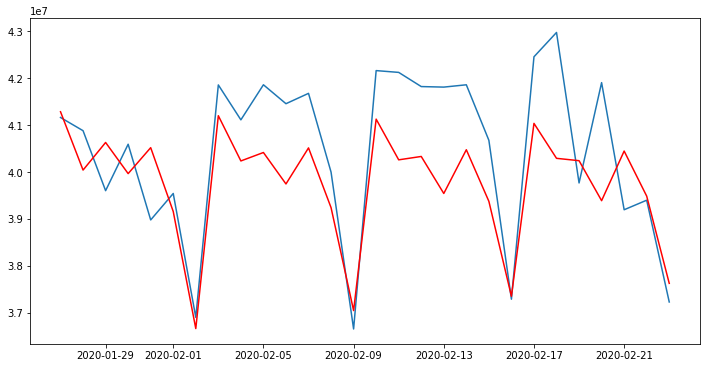

In [20]:
# The no of best lag for this data is 12 and all the correlation of the lags with the original MoU is listed

# Predicting the test values
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
print('The first test value in Sales :',test.values[1],'and its Predicted value : ',predictions.values[1])
test.head()
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [34]:
rmse = np.sqrt(mean_squared_error(test['MoU_Overall'], predictions))
rmse = round(rmse, 3)
# Mean Absolute Percentage Error
abs_error = np.abs(test['MoU_Overall']-predictions)
actual = test['MoU_Overall']
mape = np.round(np.mean(abs_error/actual),3)
resultsDf = pd.DataFrame({'Method':['Auto Regressive'], 'RMSE': [rmse]})
resultsDf
mape

# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,2178153.227,0.047


Best ARMA (6, 1) model - AIC:2744.3830296263136
Lag: 6
Coefficients: const                3.777326e+07
ar.L1.MoU_Overall    8.147362e-01
ar.L2.MoU_Overall   -2.052909e-01
ar.L3.MoU_Overall    1.071440e-01
ar.L4.MoU_Overall   -1.070322e-03
ar.L5.MoU_Overall   -1.561578e-01
ar.L6.MoU_Overall    4.190566e-01
ma.L1.MoU_Overall   -6.944102e-01
dtype: float64


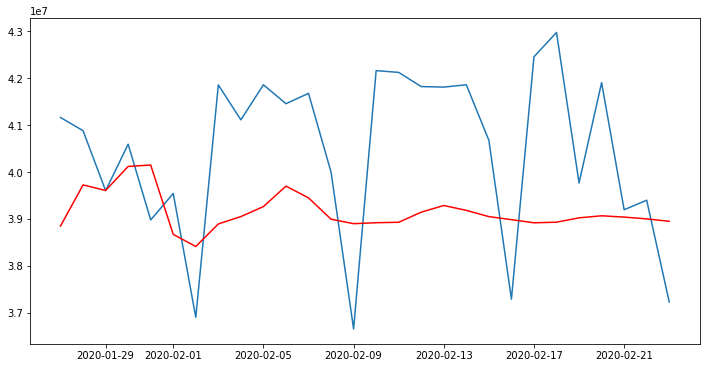

In [35]:
# Model 2: Auto Regressive Moving Average(ARMA)
# The model involves specifying the order for the AR(p) and MA(q) model
# Define the p and q parameters to take any value between 0 and 2

p = range(0, 7)
q = range(0,2)
# Generate all different combinations of p,q
pq = list(itertools.product(p,q))
# Grid Search to get the best p,q parameter
best_aic = np.inf
best_pq = None
temp_model = None
for param in pq: 
    temp_model = ARMA(train,order=param)
    results = temp_model.fit()
    if results.aic < best_aic:
        best_aic = results.aic
        best_pq = param
print("Best ARMA {} model - AIC:{}".format(best_pq,best_aic))

# using the best parameter in the model
model = ARMA(train,order=best_pq)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [36]:
rmse = np.sqrt(mean_squared_error(test['MoU_Overall'], predictions))
rmse = round(rmse, 3)
# Mean Absolute Percentage Error
abs_error = np.abs(test['MoU_Overall']-predictions)
actual = test['MoU_Overall']
mape = np.round(np.mean(abs_error/actual),3)
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Auto Regressive Moving average '], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,2178153.227,0.047
0,Auto Regressive Moving average,2178153.227,0.047


In [37]:
# Model 3: Autoregressive Integrated Moving Average (ARIMA)
# This model involves specifying the order for the AR(p), I(d), and MA(q) models

train_len = int(np.ceil(len(data) * 0.75))
train=data[0:train_len] 
test=data[train_len:]
print('Train data length :',len(train))
print('Test  data length :',len(test))

Train data length : 87
Test  data length : 28


Best ARIMA (7, 1, 0) model - AIC:2638.563544049872


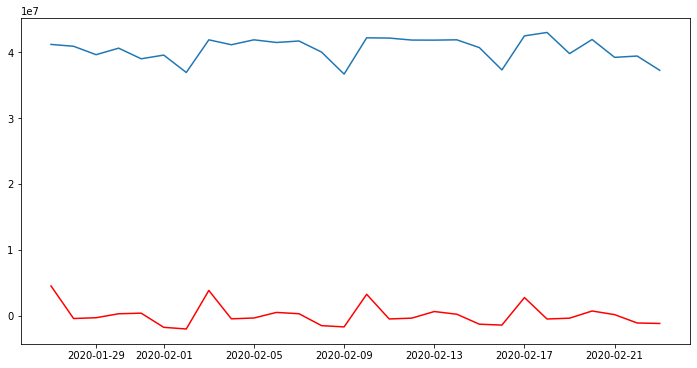

In [38]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0,8)
d = range(0,2)
q = range(0,1)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
# Grid Search to get the best p,d,q parameter
best_aic = np.inf
best_pdq = None
temp_model = None
for param in pdq:   
    temp_model = ARIMA(train,order=param)
    results = temp_model.fit()
    if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param 
print("Best ARIMA {} model - AIC:{}".format(best_pdq,best_aic))
# using the best parameter in the model
model = ARIMA(train,order=best_pdq)
model_fit = model.fit()
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [39]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test, predictions))
rmse = round(rmse, 3)
# Mean Absolute Percentage Error
abs_error = np.abs(test['MoU_Overall']-predictions)
actual = test['MoU_Overall']
mape = np.round(np.mean(np.abs(abs_error/actual)),3)
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Autoregressive Integrated Moving Average'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,2.178153e+06,0.047
0,Auto Regressive Moving average,2.178153e+06,0.047
0,Autoregressive Integrated Moving Average,4.043487e+07,1.000


In [44]:
# Seasonal Autoregressive Integrated Moving-Average (SARIMA)
# It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.

# Define the p, d and q parameters to take any value between 0 and 2
p = range(0,13)
d = range(0,13)
q = range(0,13)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdq

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# Grid Search to get the best p,d,q parameter
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
for param in pdq:   
    for param_seasonal in seasonal_pdq: 
        temp_model = SARIMAX(train,order=param,seasonal_order = param_seasonal,enforce_invertibility=False,
                             enforce_stationarity=False)
        results = temp_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
print("Best ARIMA {} x {} model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic))


ValueError: maxlag should be < nobs